# Statistical Learning - Final Lab

## Amazon Book Reviews - https://archive.ics.uci.edu/ml/datasets/Amazon+book+reviews

#### Authors: Brice Decaux, Peter Martigny, January 2017

### The goal of this project is to predict how much a reader would rate a book based on her/his textual review
### We will follow this methodology:

#### Short exploration

#### Cleaning of reviews

#### Bag of words model to create features

#### Classification & Regression algorithms to predict the ratings

#### Using [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) to embed words into contextual vectors, then use average vectors or clustering to create features for ML algorithms

In [1]:
## Some useful package imports
import pandas as pd
from bs4 import BeautifulSoup
import time
import numpy as np

import nltk
from nltk.stem.porter import *
import string
from nltk.tokenize import TweetTokenizer
token = TweetTokenizer()
stemmer = PorterStemmer() 
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
%matplotlib inline

## Load the datasets

In [2]:
# Load the first book
data = pd.read_csv('Paula_Hawkins-The-Girl-On-The-Train.csv', sep = '\t', header = None)
# Rename columns
data.columns = ['rating', 'tail', 'title', 'review']
data['book'] = 'Paula_Hawkins-The-Girl-On-The-Train'

# Load the second book
data1 = pd.read_csv('Andy-Weir-The-Martian.csv', sep = '\t', header = None)
# Rename columns
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Andy-Weir-The-Martian'

# Concatenate into one dataframe
data = pd.concat((data, data1))
# Reset index and remove the index column
data = data.reset_index().ix[:, 1:]


############## Concatenate the other books ########################

data1 = pd.read_csv('Donna-Tartt-The-Goldfinch.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Donna-Tartt-The-Goldfinch'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('EL-James-Fifty-Shades-of-Grey.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'EL-James-Fifty-Shades-of-Grey'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('Fillian_Flynn-Gone_Girl.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Fillian_Flynn-Gone_Girl'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('John-Green-The-Fault-in-our-Stars.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'John-Green-The-Fault-in-our-Stars'

data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

data1 = pd.read_csv('Laura-Hillenbrand-Unbroken.csv', sep = '\t', header = None)
data1.columns = ['rating', 'tail', 'title', 'review']
data1['book'] = 'Laura-Hillenbrand-Unbroken'

##########" Final concatenation ##############"
data = pd.concat((data, data1))
data = data.reset_index().ix[:, 1:]

print('The dataframe contains ', data.shape[0], ' rows, which consist of reviews from ', len(data.book.unique()), 
      ' different books\n')

for book in data.book.unique():
    print(book, ' has ', len(data[data.book == book]), ' reviews')

The dataframe contains  219242  rows, which consist of reviews from  7  different books

Paula_Hawkins-The-Girl-On-The-Train  has  37139  reviews
Andy-Weir-The-Martian  has  22571  reviews
Donna-Tartt-The-Goldfinch  has  22861  reviews
EL-James-Fifty-Shades-of-Grey  has  32977  reviews
Fillian_Flynn-Gone_Girl  has  41974  reviews
John-Green-The-Fault-in-our-Stars  has  35844  reviews
Laura-Hillenbrand-Unbroken  has  25876  reviews


In [3]:
data.shape

(219242, 5)

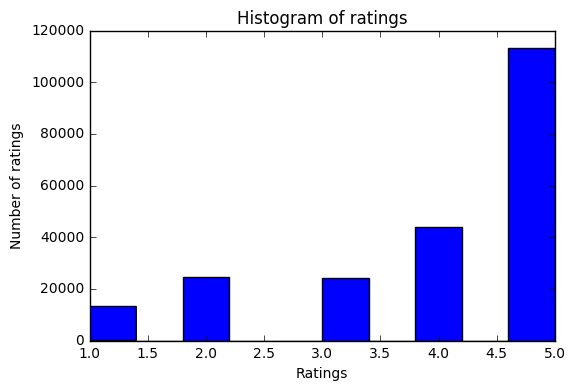

In [51]:
plt.hist(data.rating)
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
plt.title('Histogram of ratings')
plt.show()

## Let's have a look at the reviews

In [52]:
data.review[0]

'<span class="a-size-base review-text">Rachel is a woman who considers herself worthless. She feels that women are only valued for two things: their looks and their role as a mother.  She is barren and rather plain looking.  Unbeknownst to her landlady she has lost her job but continues to ride the commuter train twice a day.  Unfortunately she must pass the home of her ex-husband Tom and his new wife Anna.  They\'ve recently had a child which is something Rachel was unable to produce when she was married to him.  He\'s moved his new family into the home that he and Rachel once shared. Tom posted a picture of himself and his newborn on Facebook with the caption that he\'s never been happier.<br/><br/>Rachel, in her despondency, has taken to drinking to a point where she has blackouts and forgets that she drunk calls her husband many times a night, even shows up at his home.  Because of a signal malfunction she often finds her rail car stopped on the tracks next to her former home.  She

Damn! It looks that the reviews are in HTML format! We will remove first remove html tages. As additional pre processing, we will also remove non-letters characters, use lowercases everywhere and remove stopwords (the words that occur too often like "the", "a", ... as they might not contain a lot of information and removing them reduces a lot the dimension of the problem.

In [54]:
def process(x):
    '''
    Function to clear the html tags, then remove non-letters characters, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''

    # Clean html tags
    review = BeautifulSoup(x, "html.parser").get_text() 
    
    # Remove non letters     
    letters = re.sub("[^a-zA-Z]", " ", review) 
    
    # Lowercase and split to words
    words = letters.lower().split()                             
    
    # It appears that searching in a set in Python is much more efficient than searching in a list
    stops = set(stopwords.words("english"))                  
    
    # Remove stopwords
    text = [w for w in words if not w in stops]   
    
    # Join to produce the cleaned texts 

    return( " ".join( text ))   

We create the column with clean reviews (according to your machine, this can take a little time):

In [55]:
data['processed'] = data['review'].apply(lambda x: process(x))

In [56]:
data.processed[0]

'rachel woman considers worthless feels women valued two things looks role mother barren rather plain looking unbeknownst landlady lost job continues ride commuter train twice day unfortunately must pass home ex husband tom new wife anna recently child something rachel unable produce married moved new family home rachel shared tom posted picture newborn facebook caption never happier rachel despondency taken drinking point blackouts forgets drunk calls husband many times night even shows home signal malfunction often finds rail car stopped tracks next former home starts notice another couple live doors refers golden couple manufactures narrative lives observes day gradually become important megan golden couple disappears rachel finds integral character police investigation seen stalking neighborhood night disappearance wounds body explained megan anna look enough alike police feel may mistaken identity involved book told three voices rachel megan anna fact rachel history drunken blacko

#### Exploration of ratings

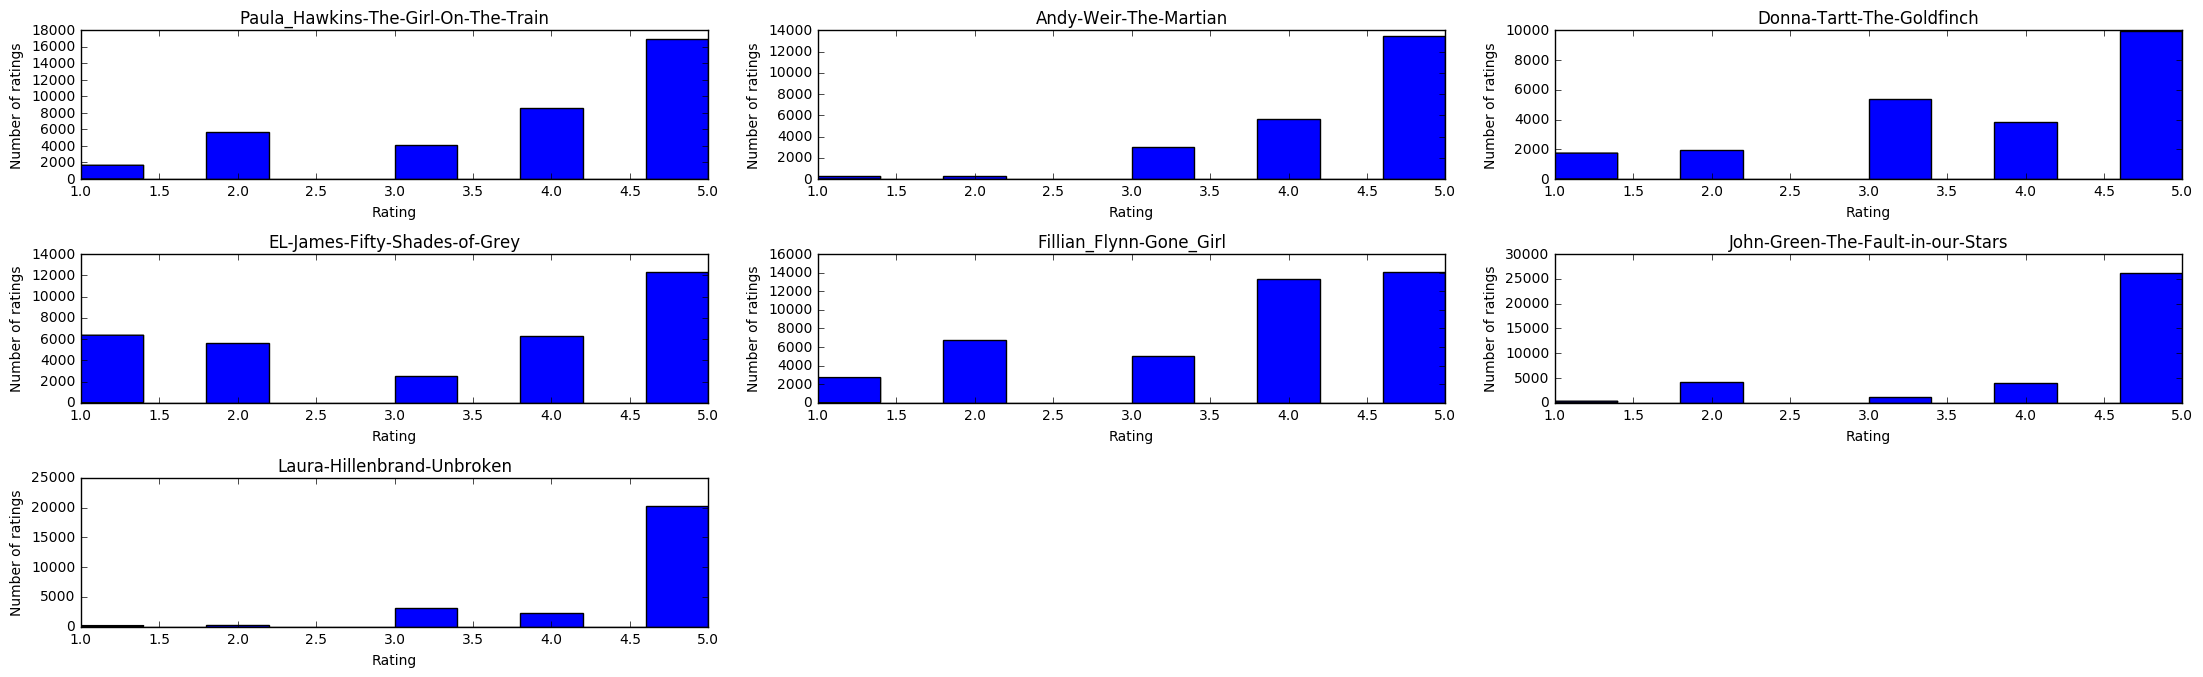

In [70]:
#Plot for the new dataset (preprocessed)
plt.figure(figsize=(22.0, 22.0))
cmptr=1
for book in data.book.unique():
    plt.subplot(10,3,cmptr)
    plt.hist(data[data.book == book]['rating'])
    plt.tight_layout(pad=0.6, w_pad=2, h_pad=1.0)
    plt.xlabel('Rating')
    plt.ylabel('Number of ratings')
    plt.title(book)
    cmptr+=1
plt.show()

We notice that some books have mostly good ratings (e.g. "Unbroken"), whereas some others have more uniform rating distributions (e.g. "Gone Girl").

## Where are we now?

We have a qute large load of reviews, each associated with a rating. We wish to build a model which predicts the rating based on the review. Hence, we wish to build a training set, composed of features built from the reviews, in order to predict the rating column.

Our foal is then to produce features from textual reviews.

## Bag of Words Model

In the model of Bag of words, we simplify the text by summarizing it as a list of distinct words, each being described by its relative frequency. Hence, we get rid of word order dependency, and observe only if a word occurs often for positive ratings or for negative ratings, and we would like to investigate if this is sufficient to predict well the ratings.

We will use the Count Vectorizer from scikit learn. Moreover, we will restraint to the $5000$ most frequent words (computation time).

In [71]:
print("Wait, bags of words are being created!!\n")
from sklearn.feature_extraction.text import CountVectorizer

# Define the function that will compute the frequencies for all words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 

# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(data['processed'])

# Convert the result to an array
train_data_features = train_data_features.toarray()

Wait, bags of words are being created!!



As the words usually appear in only a few reviews, the matrix produced is likely to be very sparse!

In [73]:
# Examine the size and the sparsity of the tfidf_matrix
size = train_data_features.shape
sparsity = np.count_nonzero(train_data_features) / train_data_features.size

print('The matrix is of shape '+str(size)+' and its sparsity is '+str(sparsity))

The matrix is of shape (219242, 5000) and its sparsity is 0.0039382399357787284


We observe that the matrix is constituted of more than $99.6 \%$ zeros!

In [75]:
print('There are ', train_data_features.shape[0], ' features and ', train_data_features.shape[1], ' features')

There are  219242  features and  5000  features


In [76]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print(vocab)

['abandon', 'abandoned', 'abilities', 'ability', 'able', 'abrupt', 'abruptly', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absurd', 'abundance', 'abuse', 'abused', 'abuser', 'abusive', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessible', 'accident', 'accidentally', 'acclaim', 'accolades', 'accomplish', 'accomplished', 'accomplishment', 'according', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'achieve', 'achieved', 'achievement', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', 'activity', 'actor', 'actors', 'acts', 'actual', 'actually', 'ad', 'adaptation', 'adapted', 'add', 'added', 'addict', 'addicted', 'addicting', 'addiction', 'addictive', 'adding', 'addition', 'additional', 'additionally', 'address', 'addressed', 'adds', 'adjectives', 'admirable', 'admiration', 'admire', 'admired', 'admit', 'admits', 'admittedly', 'adolescence', 'adolescent', 'adolescents', 'adopted', 'ado

In [77]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print(count, tag)

81 abandon
291 abandoned
76 abilities
1240 ability
4130 able
339 abrupt
237 abruptly
587 absolute
4746 absolutely
91 absorb
382 absorbed
301 absorbing
186 absurd
141 abundance
1148 abuse
342 abused
101 abuser
614 abusive
75 accent
411 accept
165 acceptable
131 acceptance
113 accepted
105 accepting
77 access
129 accessible
254 accident
137 accidentally
82 acclaim
114 accolades
105 accomplish
183 accomplished
73 accomplishment
154 according
1190 account
294 accounts
182 accuracy
876 accurate
144 accurately
139 achieve
91 achieved
82 achievement
1131 across
577 act
98 acted
182 acting
1493 action
735 actions
80 active
144 activities
108 activity
115 actor
151 actors
355 acts
893 actual
5730 actually
147 ad
191 adaptation
73 adapted
1170 add
627 added
155 addict
313 addicted
387 addicting
402 addiction
425 addictive
188 adding
360 addition
127 additional
75 additionally
219 address
74 addressed
300 adds
192 adjectives
139 admirable
125 admiration
271 admire
95 admired
1548 admit
71 admits


Let's have a look at the most used words in our corpus:

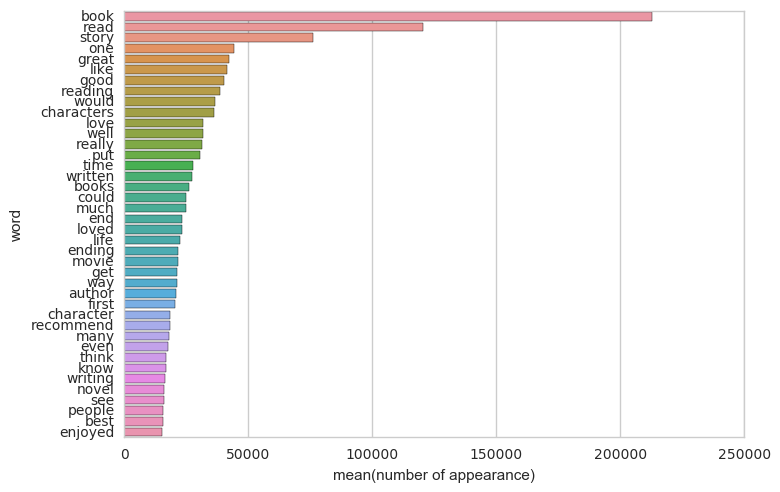

In [119]:
ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)

import seaborn as sns
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)

We observe that some of the most represented words are related to emotions ("great", "like", "good", "love", ... which is important for our application).

We observe that the number of appearance is rapidly deacreasing.

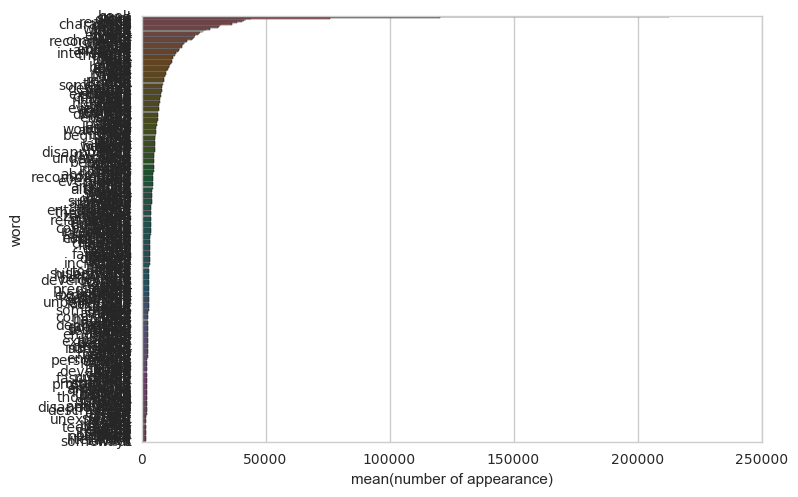

In [120]:
ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(500)
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)

## Classification

We will now build models to predict the rating based on the reviews' features.

In [123]:
# Import package to control the computation time
import time

In [122]:
labels = data['rating']

from sklearn.model_selection import train_test_split

# We split the data into train and test data. Here we keep 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression

start = time.time()

# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = 0.001)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  23.411168813705444


The accuracy is:  0.521019263224


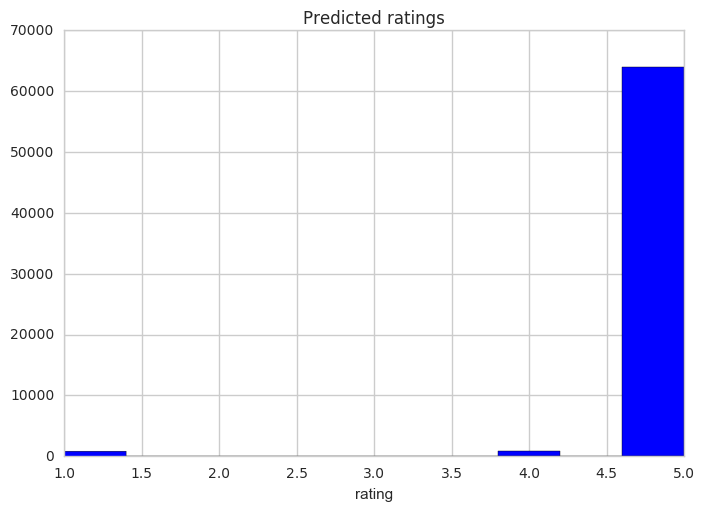

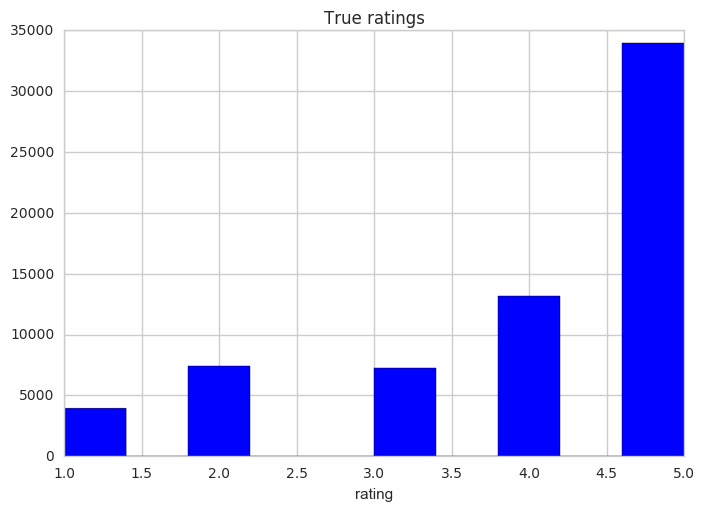

In [132]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [136]:
np.unique(labels_predicted)

array([ 1.,  2.,  3.,  4.,  5.])

#### Random Forest

In [137]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 20)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  431.06577730178833


The accuracy is:  0.49587216639


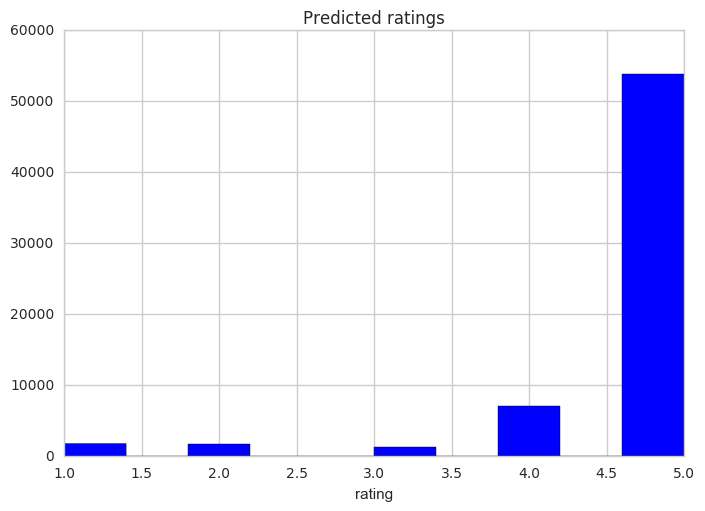

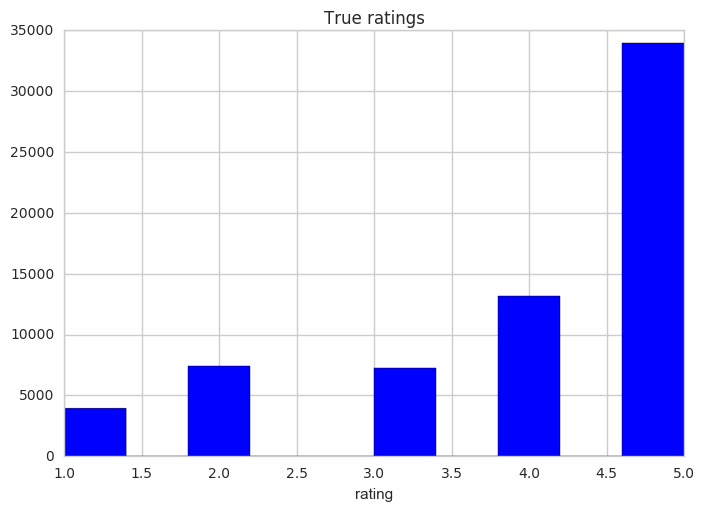

In [138]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [140]:
print(np.sum((labels_predicted - labels_test) < 3) / len(labels_test))

0.871147735393


#### Regression

Here, we wish to estimate the rating as a linear combination of the reviews' features.

In [160]:
from sklearn.linear_model import Lasso

start = time.time()

# Initialize the model
print('Initialize the model')
clf = Lasso(alpha = 0.001)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  100.90751028060913


In [172]:
def correct(x):
    if x < 0:
        res = 0
    elif x > 5:
        res = 5
        
    else:
        res = np.round(x)
        
    return res

correct(-5)

0

In [178]:
labels_predicted = [correct(x) for x in labels_predicted]

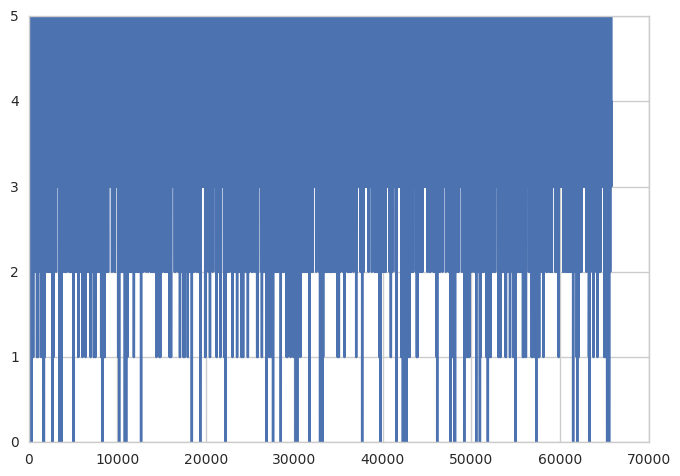

In [180]:
plt.plot(labels_predicted)
plt.show()

In [181]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

MSE error:  1.52568683198
MAE error:  1.00361850607


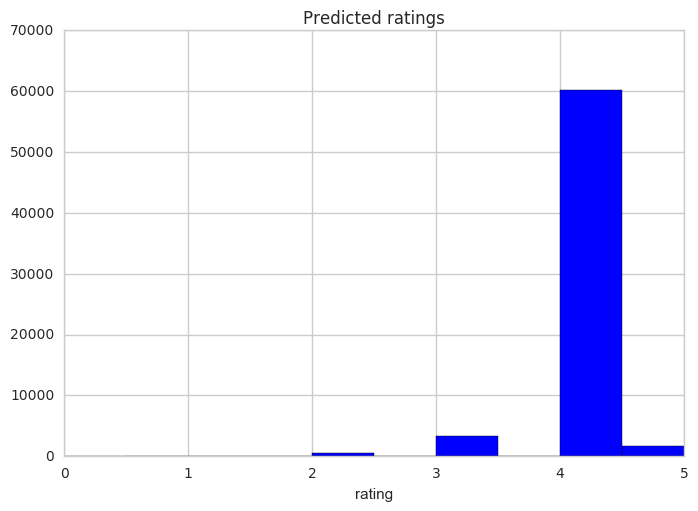

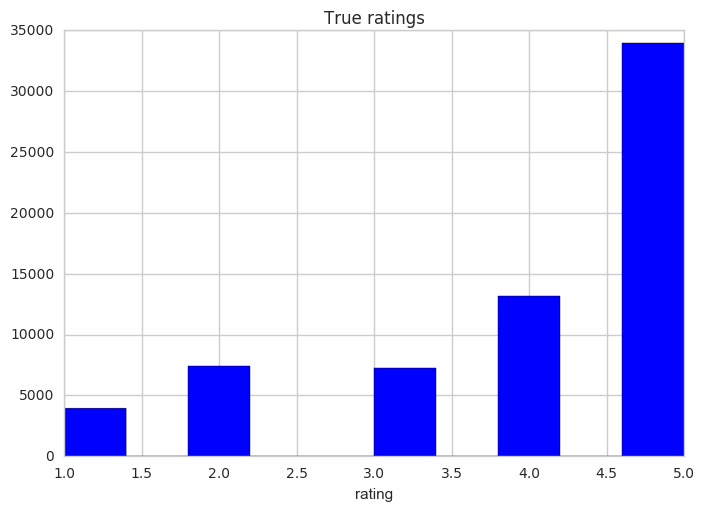

In [182]:
plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [184]:
print(np.sum((labels_predicted - labels_test) < 1) / len(labels_test))

0.722758578748


### What if we used TF-IDF instead of Count Vectorizer?

In TF-IDF (Term Frequency - Inverse Document Frequency), we take into account both the frequency of the word in the text and the relative frequency within different texts.

In [185]:
print("Wait, bags of words are being created!!\n")
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the function that will compute the frequencies for all words
vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 

# Use the fit_transform method to learn the vocabulary and then transform the training data into vectors
train_data_features = vectorizer.fit_transform(data['processed'])

# Convert the result to an array
train_data_features = train_data_features.toarray()

Wait, bags of words are being created!!



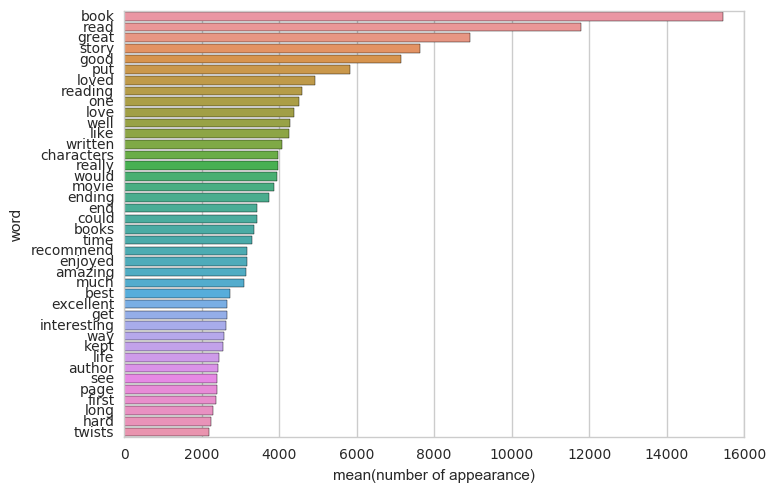

In [186]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()

# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

ex = pd.DataFrame(data = {'word': vocab, 'number of appearance': dist}).sort_values(by = 'number of appearance', 
                                                                                    ascending = False).head(40)

import seaborn as sns
sns.set_style("whitegrid")
ax = sns.barplot( x="number of appearance", y="word", data=ex)

### Classification

In [187]:
labels = data['rating']

from sklearn.model_selection import train_test_split

# We split the data into train and test data. Here we keep 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data_features, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

#### Logistic Regression

In [188]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = LogisticRegression(C = 0.001)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  21.40502429008484


The accuracy is:  0.515682726955


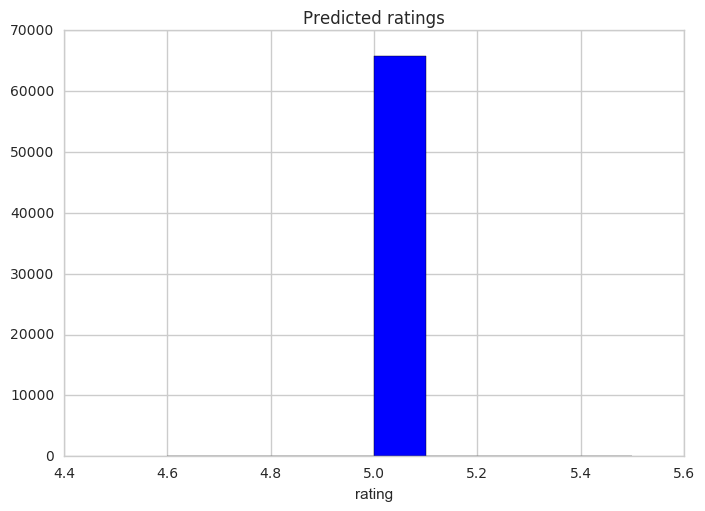

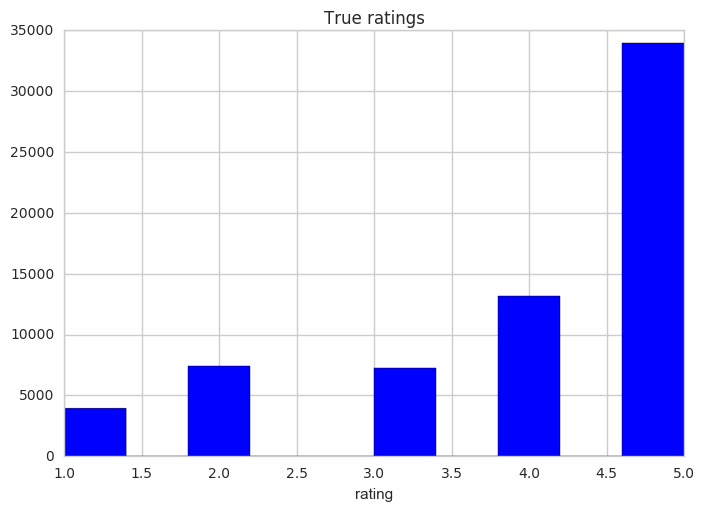

In [189]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

Here, we see that the logistic regression gives the same output all the time. The results are poorer than before.

#### Random Forest

In [190]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 20)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  452.80539560317993


The accuracy is:  0.505754640962


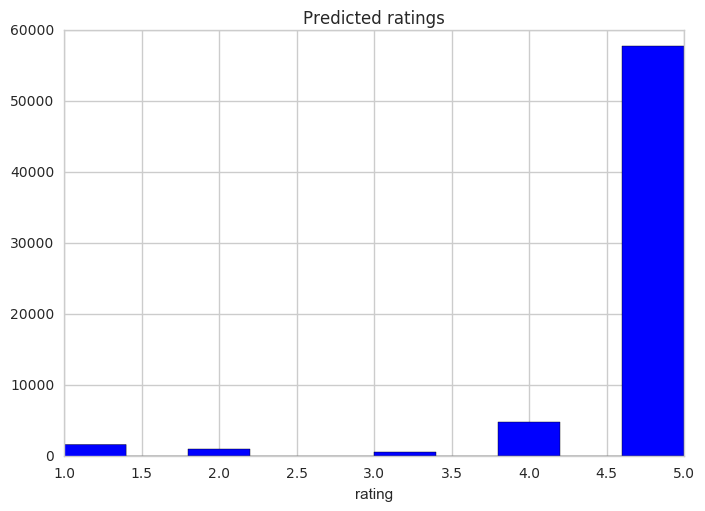

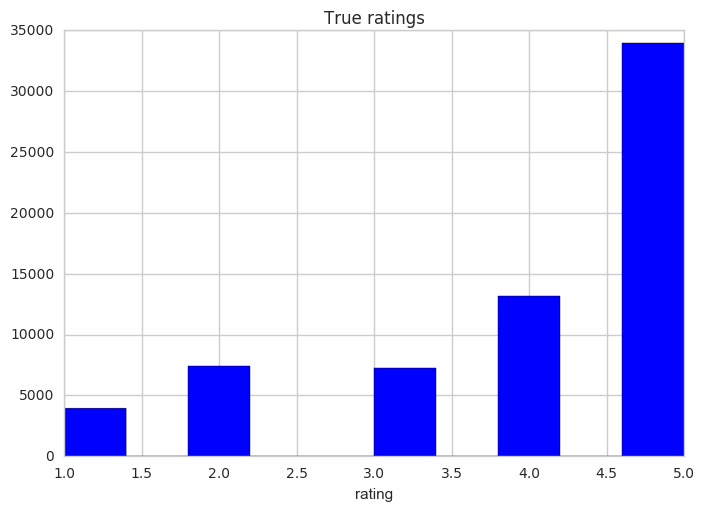

In [191]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

### Regression

#### Lasso

In [192]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = Lasso(alpha = 0.001)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  63.64929461479187


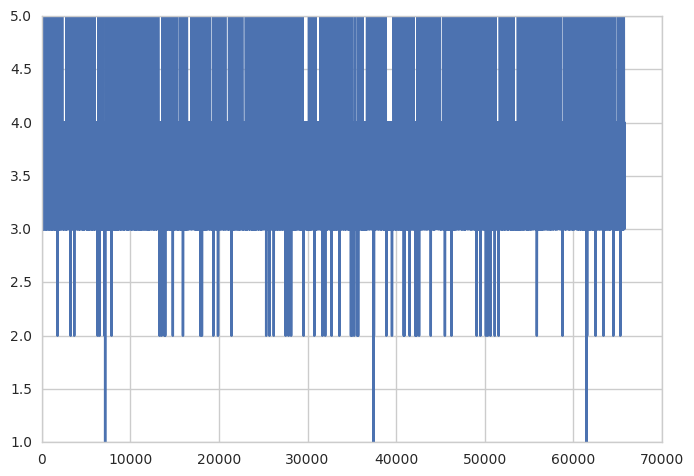

MSE error:  1.57058367415
MAE error:  1.02251683822


In [193]:
labels_predicted = [correct(x) for x in labels_predicted]

plt.plot(labels_predicted)
plt.show()

print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

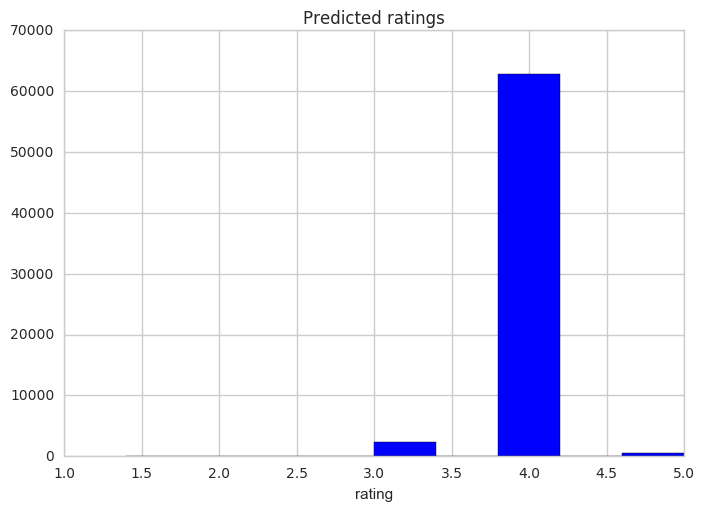

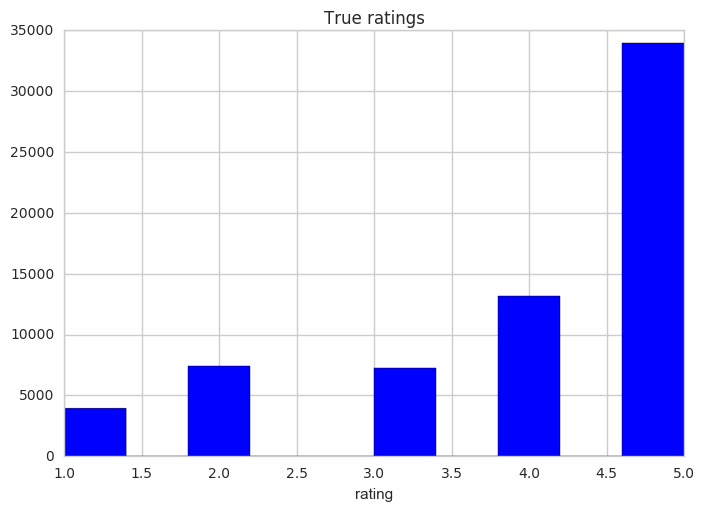

In [194]:
plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

We remark thet our algorithms have a poor performance overall, in classification and regression. This may be explained by the way we created our features. With bag of words, we consider only the frequency of a word. But what is importantr is also the context in which this word has been used. The Bag of words model does not take the context into account.

In the following, we will use another model to create features, and try to use the context of words within sentences.

# Word Embedding with Word2Vec

[Mikolov](https://scholar.google.com/citations?user=oBu8kMMAAAAJ) has contributed a lot in the field of [word embedding](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) using deep learning. His first models skip-gram and CBOW have lead to lots of work to imrove the way we embed objects into vectors (including words, in our contexts).

We will use the implementation of $Word2Vec$ from the package [Gensim](https://radimrehurek.com/gensim/).

### Prepare the data for gensim $Word2Vec$ model

In [205]:
def process(x, remove_stopwords=False):
    '''
    Function to clear the html tags, then remove non-letters characters, 
    lowercase, remove stopwords, then join the resulting as a full text
    '''
    # Clean html tags
    review = BeautifulSoup(x, "html.parser").get_text() 
    # Remove non letters     
    letters = re.sub("[^a-zA-Z]", " ", review) 
    # Lowercase and split to words
    words = letters.lower().split()                             
    # It appears that searching in a set in Python is much more efficient than searching in a list
    stops = set(stopwords.words("english"))                  
    # Optionally remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words 

In [206]:
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Function that splits reviews into sentences
def review_to_sentences(review, tokenizer, remove_stopwords=False ):
    '''Function to split a review into parsed sentences. Returns a 
    list of sentences, where each sentence is a list of words
    '''
    
    # Split into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    
    # Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(process(raw_sentence, remove_stopwords))
            
    # Return the list of sentences (each sentence is a list of words, so this returns a list of lists
    return sentences

In [207]:
# Apply the function to the whole dataset

start = time.time()

sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for review in data["review"]:
    sentences += review_to_sentences(review, tokenizer)
      
print(time.time() - start)

Parsing sentences from training set


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'..'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.. .'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)
C:\Users\P

517.4244692325592


### Build the $Word2Vec$ model and save it

We will embed words into $300$ dimensions vectors, with a context of size $10$. We only keep words which appear at least $40$ times.

In [ ]:
start = time.time()
# The logging package enables to output messages during preparation

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)


# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. This is the most costly in computation time!
from gensim.models import word2vec
print("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

model.init_sims(replace=True)

# Save the model
model_name = "300features_40minwords_10context_full_dataset"
model.save(model_name)

print(time.time() - start)

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\gensim\utils.py:843: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2017-01-15 17:34:45,679 : INFO : 'pattern' package not found; tag filters are not available for English
2017-01-15 17:34:45,690 : INFO : collecting all words and their counts
2017-01-15 17:34:45,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-01-15 17:34:45,740 : INFO : PROGRESS: at sentence #10000, processed 188196 words, keeping 8922 word types
2017-01-15 17:34:45,783 : INFO : PROGRESS: at sentence #20000, processed 355153 words, keeping 11357 word types
2017-01-15 17:34:45,821 : INFO : PROGRESS: at sentence #30000, processed 498166 words, keeping 12705 word types
2017-01-15 17:34:45,851 : INFO : PROGRESS: at sentence #40000, processed 630564 words, keeping 13729 word types
2017-01-15 17:34:45,881 : INFO : PROGRESS: at sentence

Training model...


2017-01-15 17:34:45,907 : INFO : PROGRESS: at sentence #60000, processed 836923 words, keeping 14920 word types
2017-01-15 17:34:45,931 : INFO : PROGRESS: at sentence #70000, processed 924516 words, keeping 15254 word types
2017-01-15 17:34:45,954 : INFO : PROGRESS: at sentence #80000, processed 1002926 words, keeping 15658 word types
2017-01-15 17:34:45,975 : INFO : PROGRESS: at sentence #90000, processed 1065784 words, keeping 16033 word types
2017-01-15 17:34:45,997 : INFO : PROGRESS: at sentence #100000, processed 1129453 words, keeping 16518 word types
2017-01-15 17:34:46,051 : INFO : PROGRESS: at sentence #110000, processed 1330532 words, keeping 19850 word types
2017-01-15 17:34:46,095 : INFO : PROGRESS: at sentence #120000, processed 1513515 words, keeping 21510 word types
2017-01-15 17:34:46,131 : INFO : PROGRESS: at sentence #130000, processed 1669617 words, keeping 22539 word types
2017-01-15 17:34:46,167 : INFO : PROGRESS: at sentence #140000, processed 1815041 words, keepi

## Exploration of the model we created

In [211]:
from gensim.models import Word2Vec

model = Word2Vec.load("300features_40minwords_10context_full_dataset")

2017-01-15 17:52:54,400 : INFO : loading Word2Vec object from 300features_40minwords_10context_full_dataset
2017-01-15 17:52:54,558 : INFO : loading wv recursively from 300features_40minwords_10context_full_dataset.wv.* with mmap=None
2017-01-15 17:52:54,559 : INFO : setting ignored attribute syn0norm to None
2017-01-15 17:52:54,560 : WARNING : direct access to syn0norm will not be supported in future gensim releases, please use model.wv.syn0norm
2017-01-15 17:52:54,561 : INFO : setting ignored attribute cum_table to None
2017-01-15 17:52:54,562 : INFO : loaded 300features_40minwords_10context_full_dataset
2017-01-15 17:52:54,563 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word


In [215]:
# Size of the matrice created
model.syn0.shape

2017-01-15 17:54:24,331 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


(7103, 300)

In [218]:
# Example of a word vector
model['king']

array([ 0.0495919 , -0.03368272,  0.02768374,  0.01349469,  0.0042475 ,
       -0.06573448, -0.00040707,  0.06190429, -0.05775223, -0.15945663,
        0.04597731,  0.01261767, -0.1227829 , -0.06231135,  0.06214846,
        0.05734577,  0.06356871,  0.0615186 , -0.06874783,  0.00536554,
        0.01434857,  0.01020819,  0.03899644, -0.01055337, -0.07225479,
        0.01421144, -0.04804432,  0.05165131, -0.01515017, -0.02150898,
        0.00823446,  0.03398369, -0.07291724, -0.01416953, -0.01206923,
       -0.00093811, -0.00941872,  0.12977876, -0.00147047,  0.0770001 ,
        0.02018942,  0.00801768, -0.07385345,  0.03135521, -0.00185948,
       -0.07122575, -0.01949604, -0.0208971 , -0.12699269,  0.00702821,
       -0.01753251,  0.07808218, -0.03565685, -0.02141562, -0.05614693,
       -0.02746536,  0.0212893 , -0.06602181,  0.0674521 ,  0.00257547,
        0.1056748 , -0.00122813,  0.07185125,  0.10236324,  0.00367323,
       -0.09677956,  0.08997916, -0.09249005,  0.05380692,  0.02

In [219]:
# Example of word similarity
model.most_similar('family')

[('neighbors', 0.6622191667556763),
 ('relatives', 0.6214653253555298),
 ('parents', 0.5821553468704224),
 ('sisters', 0.5591897368431091),
 ('partner', 0.5534984469413757),
 ('families', 0.5507222414016724),
 ('co', 0.5499768257141113),
 ('welty', 0.5451545119285583),
 ('colleagues', 0.5450441241264343),
 ('girlfriend', 0.5401353240013123)]

In [225]:
model.most_similar('good')

[('great', 0.6955132484436035),
 ('decent', 0.6496216058731079),
 ('nice', 0.5820240378379822),
 ('bad', 0.5301953554153442),
 ('fine', 0.5244165062904358),
 ('fantastic', 0.5166913270950317),
 ('terrific', 0.47179803252220154),
 ('solid', 0.4690036475658417),
 ('wonderful', 0.4632207751274109),
 ('fabulous', 0.4391731917858124)]

In [222]:
# Distinguished the most distant word between several words
print(model.doesnt_match("man woman child dog".split()))

print(model.doesnt_match("amazing wonderful great window".split()))

dog
window


In [224]:
# It is not perfect:
model.doesnt_match("france england germany barcelona".split())

'germany'

#### Once we have word vectors, how can we create features for reviews?

#### One possibility is to average all the word vectors from the review

In [226]:
def makeFeatureVec(words, model, num_features):
    ''' 
    Function to average all the word vectors in a given review
    '''
    # Initialize an empty array
    featureVec = np.zeros((num_features,),dtype="float32")
    
    nwords = 0.
    
    # Index2word is a list that contains the names of the words in the model's vocabulary. Convert it to a set, for speed (juyst as we did before)
    index2word_set = set(model.index2word)
    
    # Loop over each word in the review and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    ''' 
    Given a set of reviews (each one a list of words), compute 
    the average feature vector for each one and return an array
    '''
    # Initialize a counter
    counter = 0.
    
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    
    # Loop through the reviews
    for review in reviews:
        
        # Print a status message every 1000th review
        if counter%1000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))
        
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, \
           num_features)
        
        # Increment the counter
        counter = counter + 1.
    return reviewFeatureVecs

In [ ]:
start = time.time()

# Compute the average feature vectors, using the functions we defined above.

print("Creating average feature vecs for train reviews")

clean_train_reviews = []
for review in data["review"]:
    clean_train_reviews.append(process(review, remove_stopwords=True ))

trainDataVecs = getAvgFeatureVecs(clean_train_reviews, model, num_features )

print(time.time() - start)

Creating average feature vecs for train reviews


2017-01-15 18:16:57,674 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,677 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,679 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,681 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,685 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,687 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,689 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

Review 0 of 219242


2017-01-15 18:16:57,874 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,877 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,879 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,881 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,884 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,886 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:16:57,889 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

Review 1000 of 219242


2017-01-15 18:17:00,111 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:17:00,114 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:17:00,116 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:17:00,118 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:17:00,120 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:17:00,122 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:17:00,124 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

Review 100000 of 219242


2017-01-15 18:20:06,375 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:06,377 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:06,379 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:06,380 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:06,382 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:06,384 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:06,387 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

Review 101000 of 219242


2017-01-15 18:20:08,228 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:08,230 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:08,231 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:08,234 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:08,235 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:08,237 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:20:08,238 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

Review 210000 of 219242


2017-01-15 18:23:11,423 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:11,425 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:11,426 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:11,428 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:11,429 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:11,431 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:11,433 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

Review 211000 of 219242


2017-01-15 18:23:13,174 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:13,175 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:13,177 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:13,179 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:13,180 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:13,182 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word
2017-01-15 18:23:13,184 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.ind

In [230]:
labels = data['rating']

# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(trainDataVecs, 
                                                                    labels, test_size=0.3, 
                                                                    random_state=42)

In [231]:
trainDataVecs.shape

(219242, 300)

#### Logistic Regression

In [232]:
start = time.time()

# Initialize the model
clf = LogisticRegression(C = 0.001)

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print(time.time() - start)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

It appears that some nans have been produced... How many?

In [234]:
np.isnan(data_train).sum() / (data_train.shape[0] * data_train.shape[1])

0.0017527969818008848

In [235]:
X = pd.concat((pd.DataFrame(trainDataVecs), data['rating']), axis=1).dropna()
train_data = X.ix[:, :-1]
train_label = X.ix[:, -1]

# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_data, 
                                                                    train_label, test_size=0.3, 
                                                                    random_state=42)

In [236]:
start = time.time()

# Initialize the model
clf = LogisticRegression()

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print('Computation time: ', time.time() - start)

Computation time:  66.07373118400574


The accuracy is:  0.515064737243


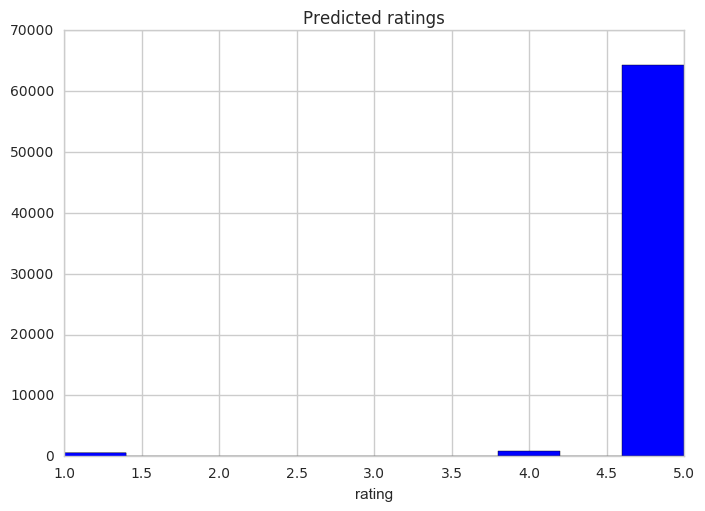

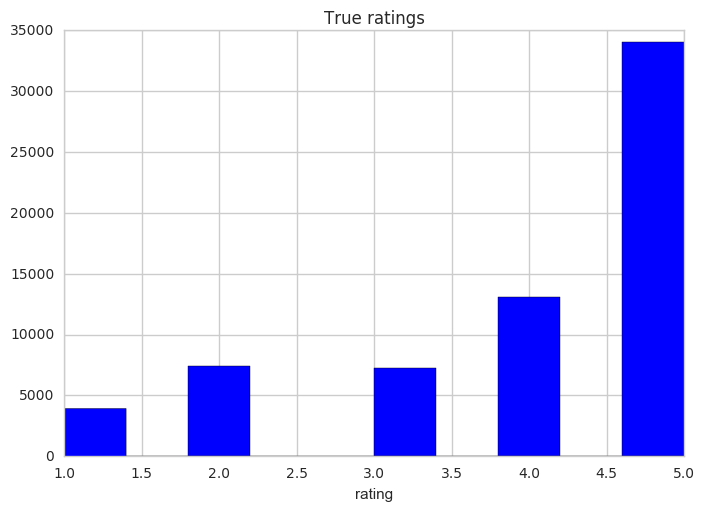

In [237]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

#### Random Forest

In [240]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 20)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  89.78312873840332


The accuracy is:  0.491744097487


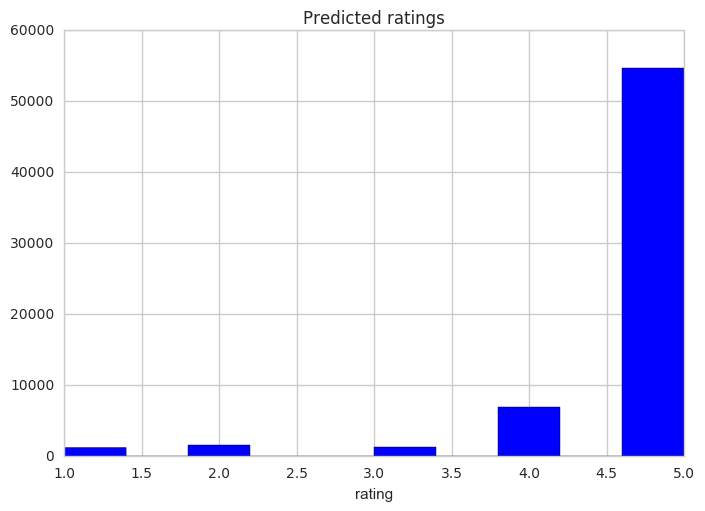

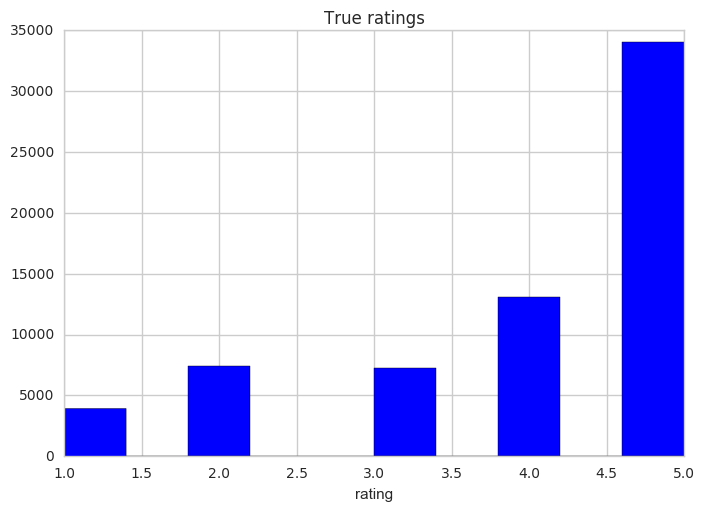

In [241]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

### Regression

#### Lasso

In [264]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = Lasso(alpha = 0.00001)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  22.698002576828003


In [265]:
labels_predicted = [correct(x) for x in labels_predicted]

print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

MSE error:  1.55405940594
MAE error:  0.998324447829


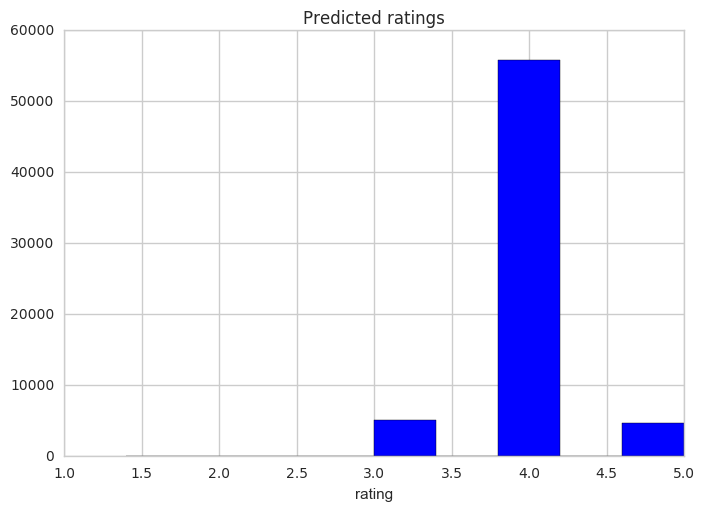

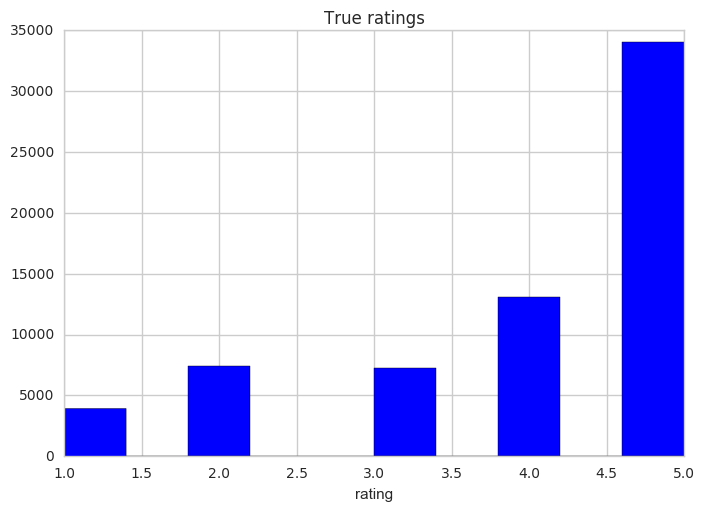

In [266]:
plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

#### Decision tree regressor

In [269]:
from sklearn.tree import DecisionTreeRegressor

start = time.time()

# Initialize the model
print('Initialize the model')
clf = DecisionTreeRegressor()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  104.74661874771118


In [271]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

The accuracy is:  0.341599390708


MSE error:  2.86379284082
MAE error:  1.21806549886


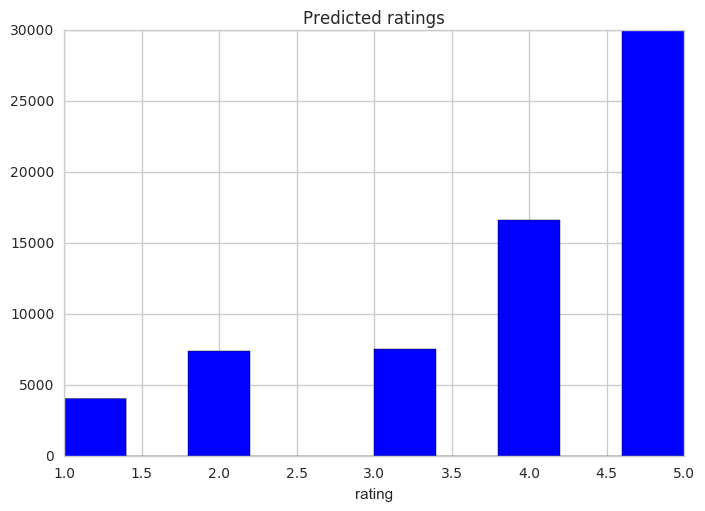

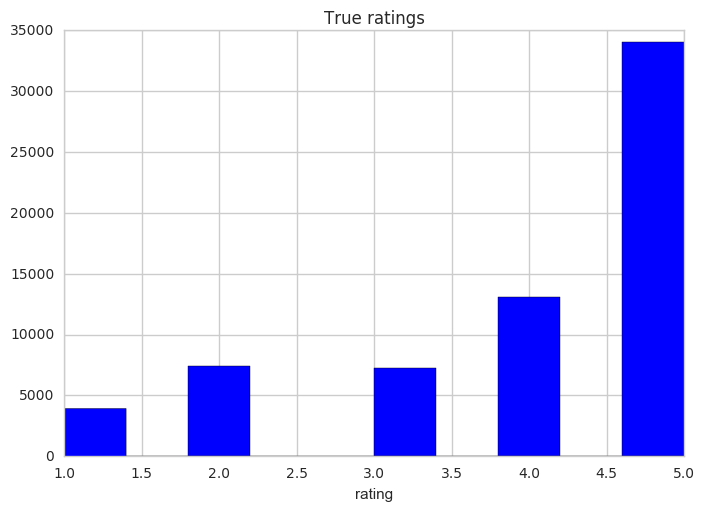

In [270]:
labels_predicted = [correct(x) for x in labels_predicted]

print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [272]:
import xgboost
start = time.time()

# Initialize the model
print('Initialize the model')
clf = xgboost.XGBRegressor()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  90.51631426811218


The accuracy is:  0.229230769231
MSE error:  1.51247524752
MAE error:  0.99226199543


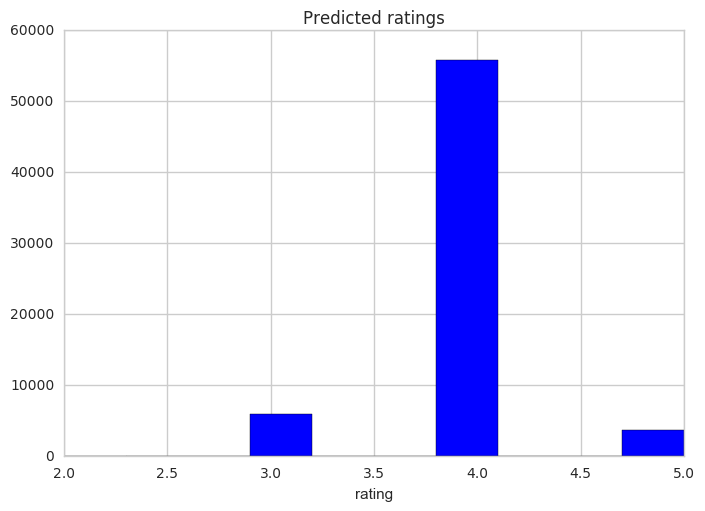

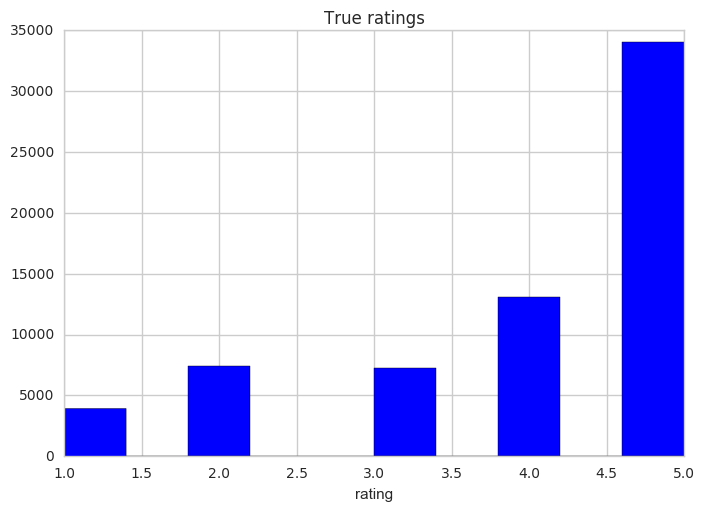

In [277]:
labels_predicted = [correct(x) for x in labels_predicted]
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))

print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [278]:
import xgboost
start = time.time()

# Initialize the model
print('Initialize the model')
clf = xgboost.XGBClassifier()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  439.99368476867676


The accuracy is:  0.523472962681
MSE error:  2.513541508
MAE error:  0.972795125666


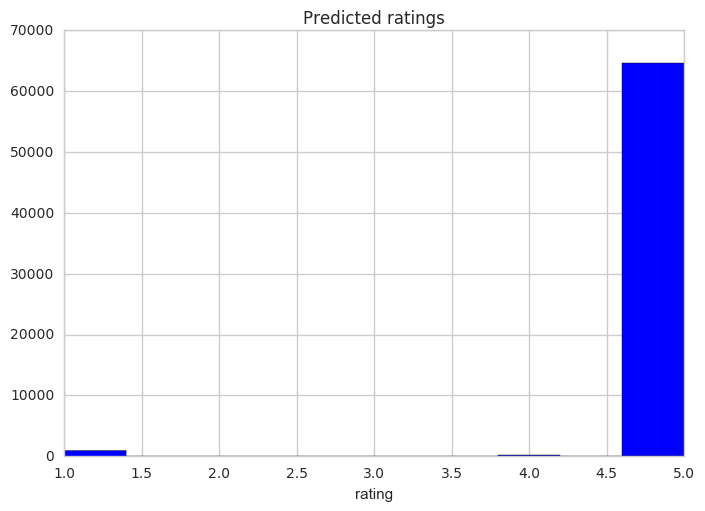

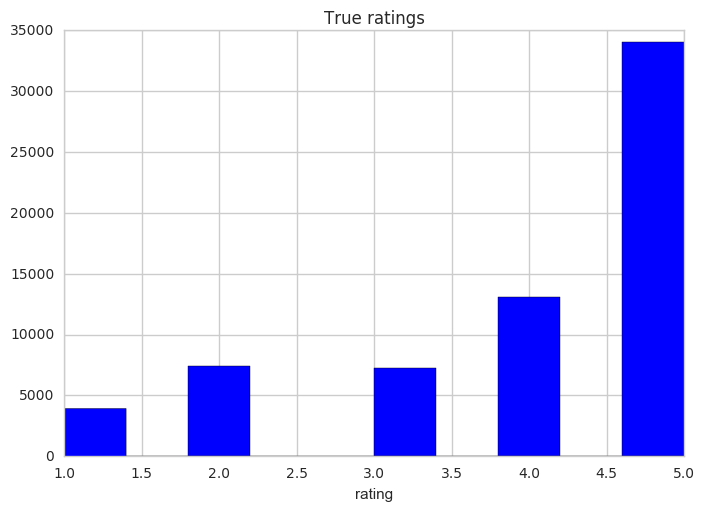

In [280]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))
print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

Sadly, it appears that $Word2Vec$ averaging vectors does not perform better than bag of words...
This is due to the fact that, by averaging, we lose the order of the words, hence recovering the drawback of bag of words.

Let's try another approach to concatenate word vectors into a review vector.

## Clustering

Since we have embedded our vectors in a $300$ dimensions space, we have a metric, and we can make clustering of words, hence producing clusters of words. We will use these clusters to create features for the reviews.

In [281]:
from sklearn.cluster import KMeans

start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size (this is an arbitrary choice)
word_vectors = model.syn0
num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

2017-01-15 19:26:09,079 : WARNING : direct access to syn0 will not be supported in future gensim releases, please use model.wv.syn0


Time taken for K Means clustering:  135.89998841285706 seconds.


In [282]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

2017-01-15 19:28:43,186 : WARNING : direct access to index2word will not be supported in future gensim releases, please use model.wv.index2word


In [283]:
# Display the first 10 clusters
for cluster in range(0,10):
    
    # Print the cluster number  
    print("\nCluster %d" % cluster)
    
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['snap', 'pointing', 'checking']

Cluster 1
['behaviour', 'behaviors', 'behavior']

Cluster 2
['remarkable', 'whew', 'glorious', 'monumental', 'magnificent']

Cluster 3
['artist', 'elderly', 'addict', 'orphaned', 'orphan', 'adolescent', 'alcoholic']

Cluster 4
['torturous', 'dreary', 'predictably']

Cluster 5
['environment', 'surviving', 'versus', 'imaginable', 'harsh', 'thrive', 'inhospitable', 'foreign', 'hostile']

Cluster 6
['paper', 'print', 'order']

Cluster 7
['tenacity', 'resourcefulness', 'strength', 'stamina', 'vulnerability', 'hardship', 'grit', 'determination', 'triumph', 'unbreakable', 'guts', 'endurance', 'optimism', 'bravery', 'fortitude', 'resilience', 'courage', 'persistence', 'dedication', 'adversity', 'spirit', 'overcoming', 'resiliency', 'ingenuity', 'perseverance', 'indomitable', 'loyalty']

Cluster 8
['demons', 'uncertain', 'treatments', 'losses', 'hapless', 'raising', 'fighting', 'forces', 'battle', 'battles', 'troubles', 'defeat', 'abuses', 'tortures'

Now, let's create our bags of centroïds

In [284]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    
    # Return the "bag of centroids"
    return bag_of_centroids

# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((data["review"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [286]:
np.isnan(train_centroids).sum() # There are no missing values

0

### Classification

#### Logistic Regression

In [288]:
# Split the data into random train and test subsets. Here we use 30% of the data for testing
data_train, data_test, labels_train, labels_test = train_test_split(train_centroids, 
                                                                    data['rating'], test_size=0.3)

start = time.time()

# Initialize the model
clf = LogisticRegression()

# Fit the model to the training data
y_score = clf.fit(data_train, labels_train).predict(data_test)
# Perform classific°ation of test data
labels_predicted = clf.predict(data_test)

print('Computation time: ', time.time() - start)

Computation time:  48.99494481086731


The accuracy is:  0.523695133261
MSE error:  2.34904900187
MAE error:  0.939899350797


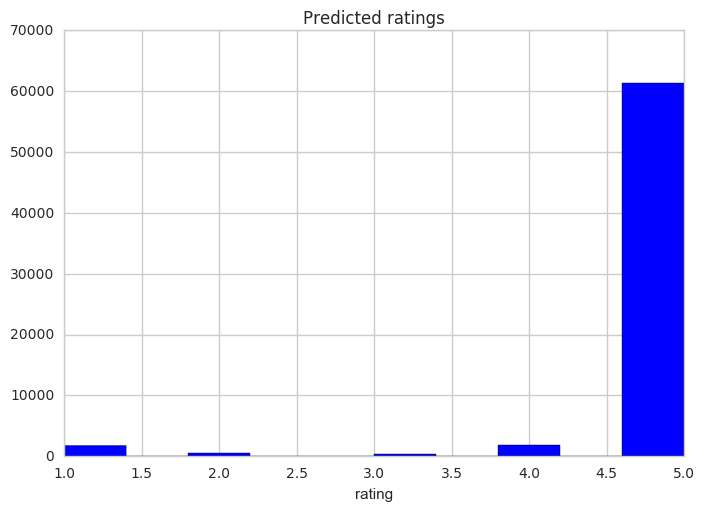

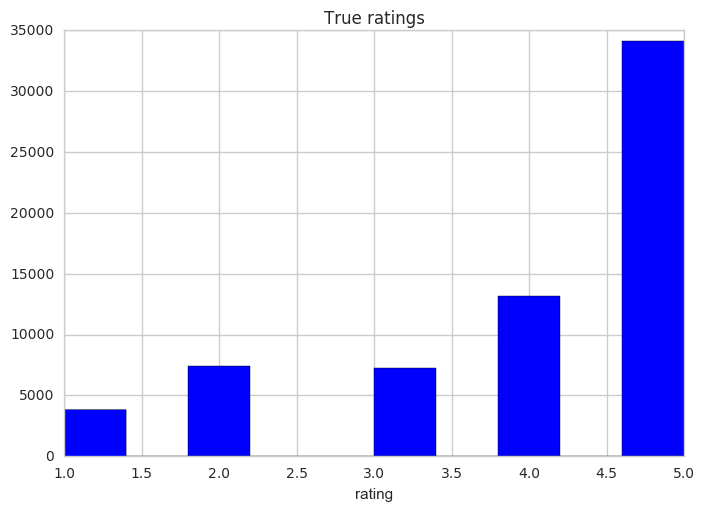

In [289]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))
print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [291]:
# Compare with always predicting 5
print("The accuracy is: ", np.sum([5 for x in labels_predicted] == labels_test) / len(labels_test))

The accuracy is:  0.518389004607


#### Random Forest

In [292]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = RandomForestClassifier(n_estimators = 20)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!
Using the model to make predictions
Computation time:  112.92619967460632


The accuracy is:  0.49362200295
MSE error:  2.31893026014
MAE error:  0.961291107293


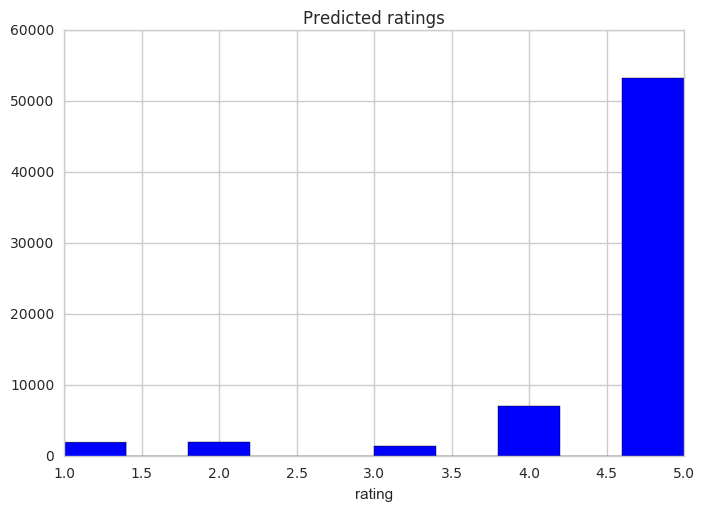

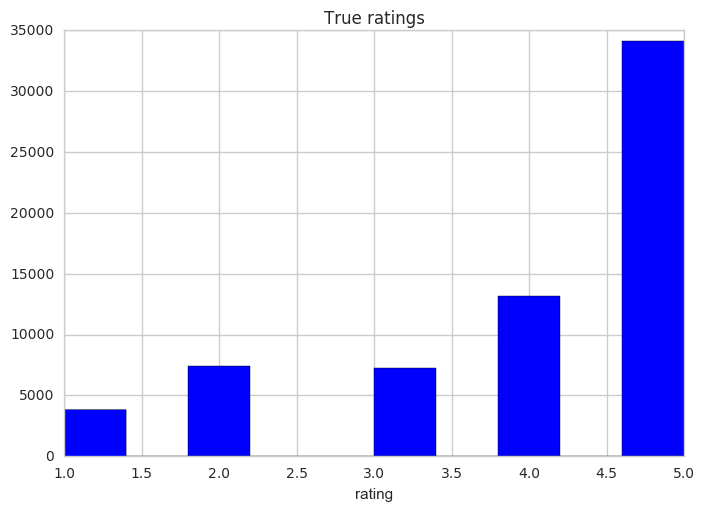

In [293]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))
print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

In [ ]:
from sklearn.svm import SVC
start = time.time()

# Initialize the model
print('Initialize the model')
clf = SVC()

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!


In [ ]:
print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))
print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

### Regression

#### Lasso

In [294]:
start = time.time()

# Initialize the model
print('Initialize the model')
clf = Lasso(alpha = 0.00001)

# Fit the model to the train data
print("Wait, the model is being learned!")
y_score = clf.fit(data_train, labels_train).predict(data_test)

# Apply the model on test data
print('Using the model to make predictions')
labels_predicted = clf.predict(data_test)

print("Computation time: ", time.time() - start)

Initialize the model
Wait, the model is being learned!


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Using the model to make predictions
Computation time:  93.19954919815063


The accuracy is:  0.227403341797
MSE error:  1.50946436988
MAE error:  0.98964620741


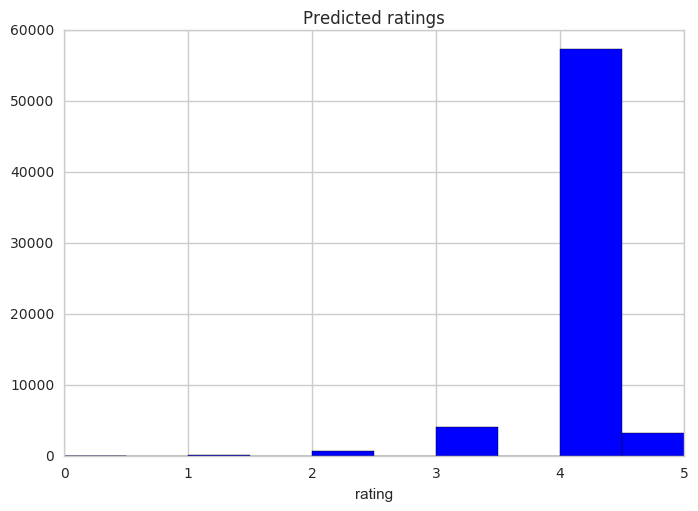

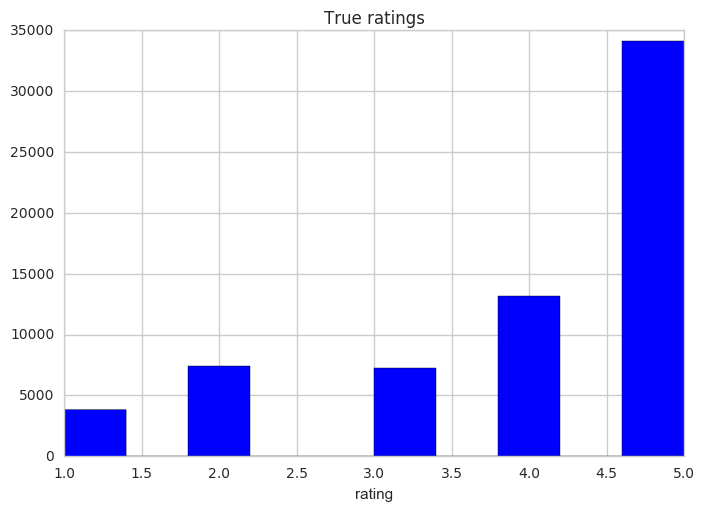

In [295]:
labels_predicted = [correct(x) for x in labels_predicted]

print("The accuracy is: ", np.sum(labels_predicted == labels_test) / len(labels_test))
print('MSE error: ', mean_squared_error(labels_predicted, labels_test))
print('MAE error: ', mean_absolute_error(labels_predicted, labels_test))

plt.hist(labels_predicted, color = 'b')
plt.xlabel('rating')
plt.title('Predicted ratings')
plt.show()

plt.hist(labels_test, color = 'b')
plt.xlabel('rating')
plt.title('True ratings')
plt.show()

# Conclusion

#### It seems that the algorithms we are designing are not doing well, even when we improve the methodology by taking the context into account.

### Some room for improvements: 

- Try different sizes for word vectors
- Try to embed paragraphs directly into vectors, with an implementation of Paragraph2Vec, or Skip Thoughts
- We could scale the ratings, to take into account the inherent bias among the different books
- We could also change the problem by trying to predict a binary sentiment: taking as positive all ratings superior to $4$, and negative all ratings inferior to $4$. We would then have a binary classification task to carry.